In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from datetime import datetime
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%run '../codes/self_defined_function.py'

In [2]:
# load data
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
#df = pd.read_excel('../data/Artikelbewegungen.xlsx')

In [3]:
columns = ["Bew_Typ", "BewSchl", "BewTxt", "BewSchl2", "LagerOrt", "Art_Typ", "ArtGrp", "ArtNr", "Bew_Datum", "Bew_Jahr", "Bew_Monat", "Menge", "EinheitNr", "Einheit", "Lief_Kd_Nr", "Best_Auft_Nr"]

In [4]:
df.columns = columns

In [5]:
df.head()

,Bew_Typ,BewSchl,BewTxt,BewSchl2,LagerOrt,Art_Typ,ArtGrp,ArtNr,Bew_Datum,Bew_Jahr,Bew_Monat,Menge,EinheitNr,Einheit,Lief_Kd_Nr,Best_Auft_Nr
0,Take On,0,NaN,TO,11,FW,8,8030696,1996/1/1 0:00:00,1996,1,500.000,23,kg,nan,0.000
1,Take On,0,NaN,TO,0,FW,8,8030725,1996/1/1 0:00:00,1996,1,175.000,23,kg,nan,0.000
2,Take On,0,NaN,TO,11,FW,8,8030725,1996/1/1 0:00:00,1996,1,450.000,23,kg,nan,0.000
3,Take On,0,NaN,TO,11,FW,8,8030796,1996/1/1 0:00:00,1996,1,1000.000,23,kg,nan,0.000
4,Take On,0,NaN,TO,0,FW,8,8030825,1996/1/1 0:00:00,1996,1,125.000,23,kg,nan,0.000


# Interesting data
only view same importance features: Bew_Datum(>2005), Menge(only), ArtNr, ArtGrp
### Data filter
- Data filter: Bew_Datum(>2005), Menge(only ), ArtNr(first 6), ArtGrp(1-19)
- the menge features of the verkauf data should be negative, but there are 3506(of 389176) positve found in the dataset
- exist duplications

### Change Menge to positive
### plot number of record je ArtNr
- most article has less than 3000 records(only 24 items excess this number), which means, they don't have enough data to train the model
- for ArtNr 205002(in 4th place), which habe 6970 records, only has records in 2002 different days from 2848 days(from 2005 to 2013), In 30% Datum ist this value Null.

### detect extrem value in each features
- min value of Menge is 0.1, is it right? what is the min value of Menge normally

### plot the trend of Menge for article
- can not find the trend manual
- long tride means they rest in janural 

### fill lack data and plot the trend again

### view the purchasing power of each buyer
- after gaussian distribution?

### view the purchasing power of one time buyer
- there is trend for the number of one time buyer
- there should be a some activity or speicy policy in some year

### view the cycle of big order
- most orders are small orders. Is there any relationship between then and the big oder(may be for the some buyer)

### view the cycle of big order for a special article

df.iloc[636,:]

## Data filter

In [37]:
df = df[df['Bew_Jahr'] >= 2005][['Bew_Typ', 'Bew_Datum', 'Bew_Jahr', 'ArtNr', 'ArtGrp', 'Menge', 'Lief_Kd_Nr']]
df = df[df['Bew_Typ'] == 'Verkauf']
df = df[df['ArtGrp'] < 20]
df['ArtNr'] = df['ArtNr'].map(lambda x: str(x)[:6])
df['Bew_Datum'] = pd.to_datetime(df['Bew_Datum'], dayfirst=True)
#df['Menge'] = df['Menge'].map(lambda x: x.replace(',', '.'))
#df['Menge'] = pd.to_numeric(df['Menge'])  
df = df[df['Menge'] < 0]
df['weekday'] = df['Bew_Datum'].map(lambda x: x.weekday)

In [7]:
len(df.drop_duplicates())

532982

In [8]:
len(df)

547311

In [9]:
df = df.drop_duplicates()

In [36]:
df['Bew_Datum'].map(lambda x: x.weekday())

AttributeError: 'Timestamp' object has no attribute 'is_weekday'

## Change menge to positive

In [10]:
df['Menge'] = -df['Menge']

## Plot number of record je ArtNr

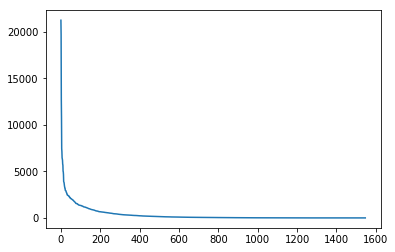

In [11]:
tmp = df['ArtNr'].value_counts()
tmp = tmp.to_list()
plt.plot(tmp)

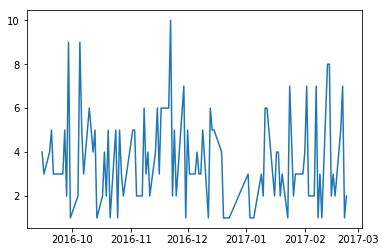

In [12]:
df['count'] = 1
tmp = df[df['ArtNr'] == '205002'][['Bew_Datum', 'count']].groupby('Bew_Datum').sum()
plt.plot(tmp[2500:2600])

In [13]:
df['count'] = 1
tmp = df[df['ArtNr'] == '904223'][['Bew_Datum', 'count']].groupby('Bew_Datum').sum()

In [14]:
len(tmp)

2741

In [15]:
df['ArtNr'].value_counts()

200032    21236
201612    19676
904213    12692
205002    10729
120100     7460
102012     7125
230112     6457
904223     6353
410102     6220
412032     5781
412012     5681
804602     5016
201312     4957
824122     4647
180426     3906
230212     3828
824159     3791
200072     3575
905122     3435
180464     3331
180465     3205
850859     3196
121010     2997
824152     2936
850857     2924
200113     2919
101522     2886
100000     2769
102252     2738
604112     2701
          ...  
827222        1
191006        1
190842        1
802412        1
602062        1
101633        1
803049        1
193108        1
192111        1
101059        1
190311        1
817042        1
180511        1
200022        1
999022        1
180602        1
809412        1
110421        1
180503        1
191341        1
191995        1
163402        1
102313        1
193102        1
110424        1
146622        1
911223        1
163201        1
190564        1
191131        1
Name: ArtNr, Length: 154

### detect extrem value in each features

In [16]:
df.describe()

,Bew_Jahr,ArtGrp,Menge,Lief_Kd_Nr,count
count,532982.000,532982.000,532982.000,532982.000,532982.000
mean,2011.694,6.754,227.747,3016.373,1.000
std,4.161,4.484,425.275,1833.913,0.000
min,2005.000,1.000,0.100,1.000,1.000
25%,2008.000,2.000,50.000,1416.000,1.000
50%,2012.000,8.000,100.000,2882.000,1.000
75%,2015.000,9.000,225.000,5062.000,1.000
max,2019.000,19.000,13860.000,9900.000,1.000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532982 entries, 478456 to 1374220
Data columns (total 8 columns):
Bew_Typ       532982 non-null object
Bew_Datum     532982 non-null datetime64[ns]
Bew_Jahr      532982 non-null int64
ArtNr         532982 non-null object
ArtGrp        532982 non-null int64
Menge         532982 non-null float64
Lief_Kd_Nr    532982 non-null float64
count         532982 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 36.6+ MB


## plot the trend of Menge for article

<Figure size 1440x720 with 0 Axes>

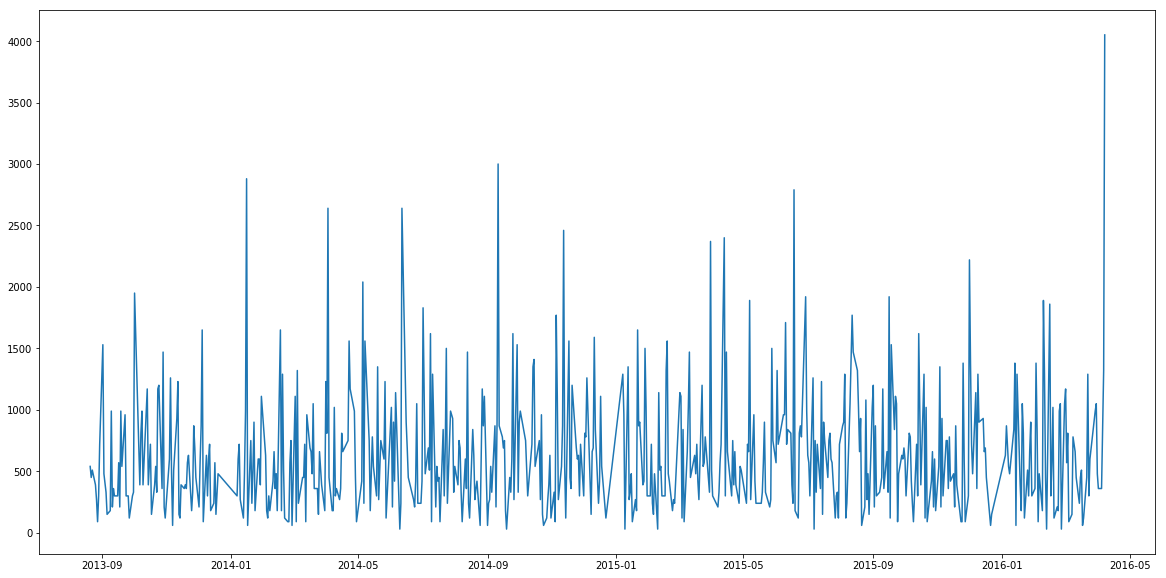

In [18]:
df['count'] = 1
tmp = df[df['ArtNr'] == '904213'][['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
plt.figure(figsize=(20, 10))
plt.plot(tmp[2000:2600])
#plt.plot(tmp)

In [19]:
df['ArtNr'].value_counts()

200032    21236
201612    19676
904213    12692
205002    10729
120100     7460
102012     7125
230112     6457
904223     6353
410102     6220
412032     5781
412012     5681
804602     5016
201312     4957
824122     4647
180426     3906
230212     3828
824159     3791
200072     3575
905122     3435
180464     3331
180465     3205
850859     3196
121010     2997
824152     2936
850857     2924
200113     2919
101522     2886
100000     2769
102252     2738
604112     2701
          ...  
827222        1
191006        1
190842        1
802412        1
602062        1
101633        1
803049        1
193108        1
192111        1
101059        1
190311        1
817042        1
180511        1
200022        1
999022        1
180602        1
809412        1
110421        1
180503        1
191341        1
191995        1
163402        1
102313        1
193102        1
110424        1
146622        1
911223        1
163201        1
190564        1
191131        1
Name: ArtNr, Length: 154

## fill lack data and plot the trend again

In [20]:
# create empty grid
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)

In [ ]:
# choose the target article and agg the menge
df_200 = df[df['ArtNr'] == '200032'][['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

<Figure size 1440x720 with 0 Axes>

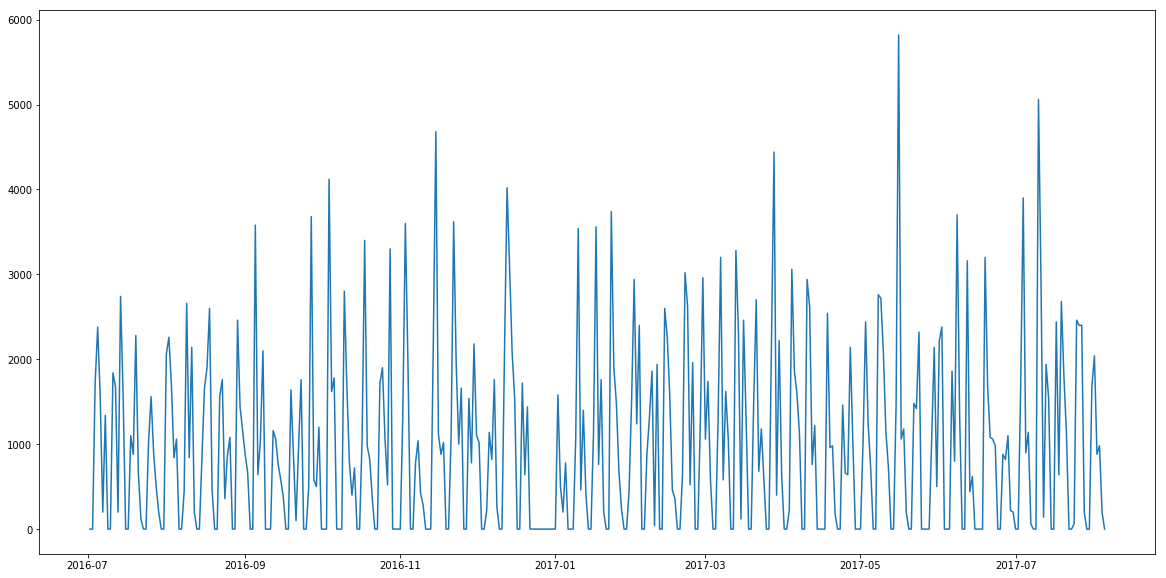

In [31]:
# plot 
plt.figure(figsize=(20, 10))
plt.plot(df_200[4200:4600])

In [29]:
pd.to_pickle(df_200, '../results/df_200.pkl')

## view the purchasing power of greatest buyer

!!!!do not find the consistency between the big buyer jet

In [32]:
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
df = preprocessing(df)

In [33]:
df.head()

,Bew_Typ,Bew_Datum,Bew_Jahr,ArtNr,ArtGrp,Menge,Lief_Kd_Nr,weekday
478456,Verkauf,2005-01-03,2005,121010,12,250.000,1652.000,0
478458,Verkauf,2005-01-03,2005,506012,5,50.000,1389.000,0
478459,Verkauf,2005-01-03,2005,180400,18,100.000,3932.000,0
478461,Verkauf,2005-01-03,2005,180405,18,10.000,2818.000,0
478462,Verkauf,2005-01-03,2005,201212,2,140.000,2613.000,0


In [4]:
df['Lief_Kd_Nr'].value_counts()

5582.000    13333
5064.000    11212
845.000     11057
3913.000     9564
566.000      9022
1775.000     8116
2624.000     8080
3674.000     7732
5695.000     7728
5033.000     7637
5175.000     7337
5171.000     7177
5081.000     7163
1521.000     6996
1774.000     6939
432.000      6852
2895.000     6584
2995.000     6486
5069.000     6224
1851.000     6093
1416.000     5412
1933.000     5395
5649.000     5163
2526.000     4999
2600.000     4920
229.000      4680
513.000      4661
4094.000     4495
5463.000     4286
4837.000     4230
            ...  
382.000         1
254.000         1
228.000         1
424.000         1
5577.000        1
5564.000        1
5475.000        1
5403.000        1
4391.000        1
832.000         1
2798.000        1
530.000         1
5412.000        1
2769.000        1
4389.000        1
5427.000        1
5444.000        1
1375.000        1
1303.000        1
5501.000        1
86.000          1
118.000         1
2712.000        1
5526.000        1
1383.000  

In [6]:
df = df[df['Lief_Kd_Nr'] == 5582.0]

In [10]:
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)
# choose the target article and agg the menge
df_200 = df[['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

(array([13.,  7.,  3.,  0.,  5.,  3.,  1.,  4.,  2.,  6.,  8., 10.,  8.,
         8., 14., 18., 20., 16., 18., 22., 20., 23., 25., 29., 23., 27.,
        32., 22., 25., 28., 19., 15.,  7., 31., 15., 11., 12., 15., 12.,
         8.,  9., 11., 10.,  9.,  8.,  6.,  6.,  9.,  5.,  6.,  4.,  4.,
         3.,  2.,  4.,  1.,  4.,  2.,  7.,  1.,  0.,  0.,  1.,  4.,  2.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([6.00000e+00, 9.10400e+01, 1.76080e+02, 2.61120e+02, 3.46160e+02,
        4.31200e+02, 5.16240e+02, 6.01280e+02, 6.86320e+02, 7.71360e+02,
        8.56400e+02, 9.41440e+02, 1.02648e+03, 1.11152e+03, 1.19656e+03,
        1.28160e+03, 1.36664e+03, 1.45168e+03, 1.53672e+03, 1.62176e+03,
        1.70680e+03, 1.79184e+03, 1.87688e+03, 1.96192e+03, 2.04696e+03,
        2.13200e+03, 2.21704e+03, 2.30208e+03, 2.38712e+03, 2.47216e+

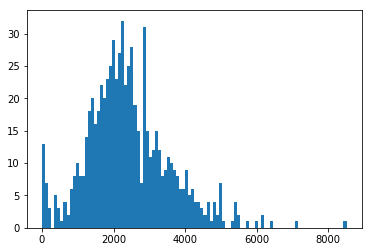

In [12]:
plt.hist(df_200[df_200['Menge'] != 0].values, bins = 100)
#tmp1 = tmp[tmp['Menge'] == 0]


In [13]:
tmp = df[df['Lief_Kd_Nr'] == 5582.0]

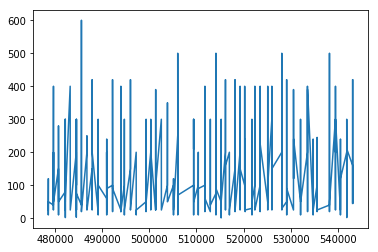

In [20]:
plt.plot(tmp['Menge'].iloc[:1000,])

## view the purchasing power of one time buyer

In [34]:
tmp2 = pd.DataFrame(df['Lief_Kd_Nr'].value_counts())

In [36]:
tmp2.columns = ['count']

In [38]:
tmp2['Lief_Kd_Nr'] = tmp2.index

In [42]:
tmp2 = tmp2.reset_index().iloc[:, 1:]

In [44]:
df = pd.merge(df, tmp2, on = 'Lief_Kd_Nr', how = 'left')

In [54]:
tmp = df[df['count'] <2]

In [61]:
tmp3 = pd.DataFrame(tmp['Bew_Jahr'].value_counts())

Text(0.5, 1.0, 'number of buyer in each year, which appear once in the dataset')

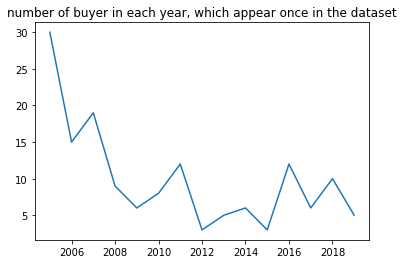

In [66]:
plt.plot(tmp3.sort_index())
plt.title('number of buyer in each year, which appear once in the dataset')

Text(0.5, 1.0, 'Purchse-ability of the ont-time customer')

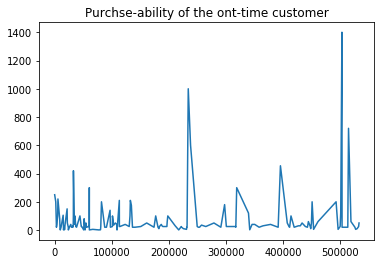

In [74]:
plt.plot(tmp['Menge'])
plt.title('Purchse-ability of the ont-time customer')

(array([23., 60., 18., 10.,  4.,  2.,  0., 10.,  2.,  1.,  1.,  0.,  2.,
         0.,  6.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.00000e+00, 1.49900e+01, 2.89800e+01, 4.29700e+01, 5.69600e+01,
        7.09500e+01, 8.49400e+01, 9.89300e+01, 1.12920e+02, 1.26910e+02,
        1.40900e+02, 1.54890e+02, 1.68880e+02, 1.82870e+02, 1.96860e+02,
        2.10850e+02, 2.24840e+02, 2.38830e+02, 2.52820e+02, 2.66810e+02,
        2.80800e+02, 2.94790e+02, 3.08780e+02, 3.22770e+02, 3.36760e+02,
        3.50750e+02, 3.64740e+02, 3.78730e+02, 3.92720e+02, 4.06710e+

Text(0.5, 1.0, 'Purchse-ability of one time buyer')

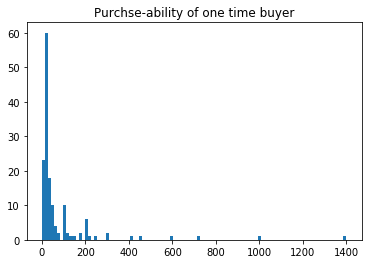

In [92]:
tmp = df[df['count'] <2]
#tmp[tmp['Menge'] < 10]['Menge'].value_counts()
plt.hist(tmp[tmp['Menge']!=0]['Menge'].values, bins = 100)
plt.title('Purchse-ability of one time buyer')

Text(0.5, 1.0, 'Purchse-ability of the few-time custommer, < 10')

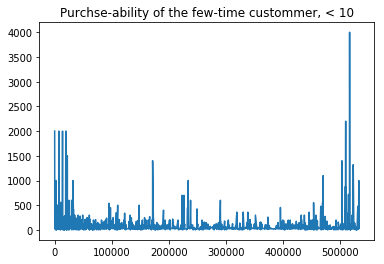

In [79]:
plt.plot(df[df['count'] < 10]['Menge'])
plt.title('Purchse-ability of the few-time custommer, < 10')

(array([1.085e+03, 3.070e+02, 1.540e+02, 8.200e+01, 7.800e+01, 2.200e+01,
        1.600e+01, 2.200e+01, 1.100e+01, 3.000e+00, 4.000e+00, 7.000e+00,
        7.000e+00, 7.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

Text(0.5, 1.0, 'Purchse-ability of few time buyer')

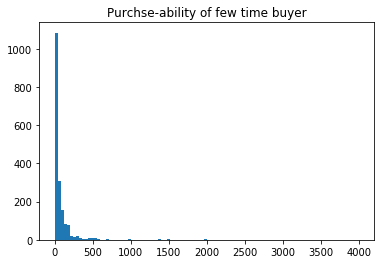

In [94]:
tmp = df[df['count'] <10]
#tmp[tmp['Menge'] < 10]['Menge'].value_counts()
plt.hist(tmp[tmp['Menge']!=0]['Menge'].values, bins = 100)
plt.title('Purchse-ability of few time buyer')

## view the cycle of big order

In [80]:
df.head()

,Bew_Typ,Bew_Datum,Bew_Jahr,ArtNr,ArtGrp,Menge,Lief_Kd_Nr,weekday,count
0,Verkauf,2005-01-03,2005,121010,12,250.000,1652.000,0,1068
1,Verkauf,2005-01-03,2005,506012,5,50.000,1389.000,0,14
2,Verkauf,2005-01-03,2005,180400,18,100.000,3932.000,0,846
3,Verkauf,2005-01-03,2005,180405,18,10.000,2818.000,0,66
4,Verkauf,2005-01-03,2005,201212,2,140.000,2613.000,0,15


(array([3.27865e+05, 9.02080e+04, 3.39330e+04, 2.21290e+04, 1.75130e+04,
        1.31540e+04, 1.73500e+03, 1.34010e+04, 2.03200e+03, 4.66000e+02,
        2.58500e+03, 6.26000e+02, 5.64000e+02, 2.18000e+02, 2.41300e+03,
        8.94000e+02, 1.40000e+02, 2.17000e+02, 1.33000e+02, 1.81000e+02,
        2.83000e+02, 6.92000e+02, 6.30000e+01, 1.70000e+02, 3.10000e+01,
        1.29000e+02, 3.10000e+01, 5.60000e+01, 2.65000e+02, 4.50000e+01,
        7.70000e+01, 5.30000e+01, 2.10000e+01, 5.30000e+01, 2.50000e+01,
        5.40000e+01, 1.18000e+02, 2.30000e+01, 3.40000e+01, 2.10000e+01,
        2.20000e+01, 2.00000e+01, 3.10000e+01, 6.30000e+01, 8.00000e+00,
        2.10000e+01, 9.00000e+00, 2.20000e+01, 1.30000e+01, 7.00000e+00,
        2.00000e+01, 1.30000e+01, 9.00000e+00, 1.00000e+00, 1.00000e+01,
        2.00000e+00, 0.00000e+00, 5.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00

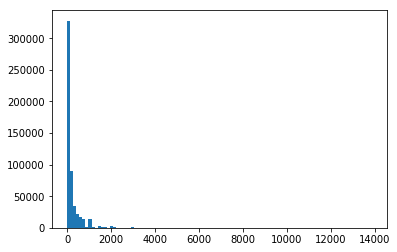

In [96]:
plt.hist(df[df['Menge'] != 0]['Menge'].values, bins = 100)

In [154]:
tmp = df[df['Menge'] > 4000]

START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)
# choose the target article and agg the menge
df_200 = tmp[['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

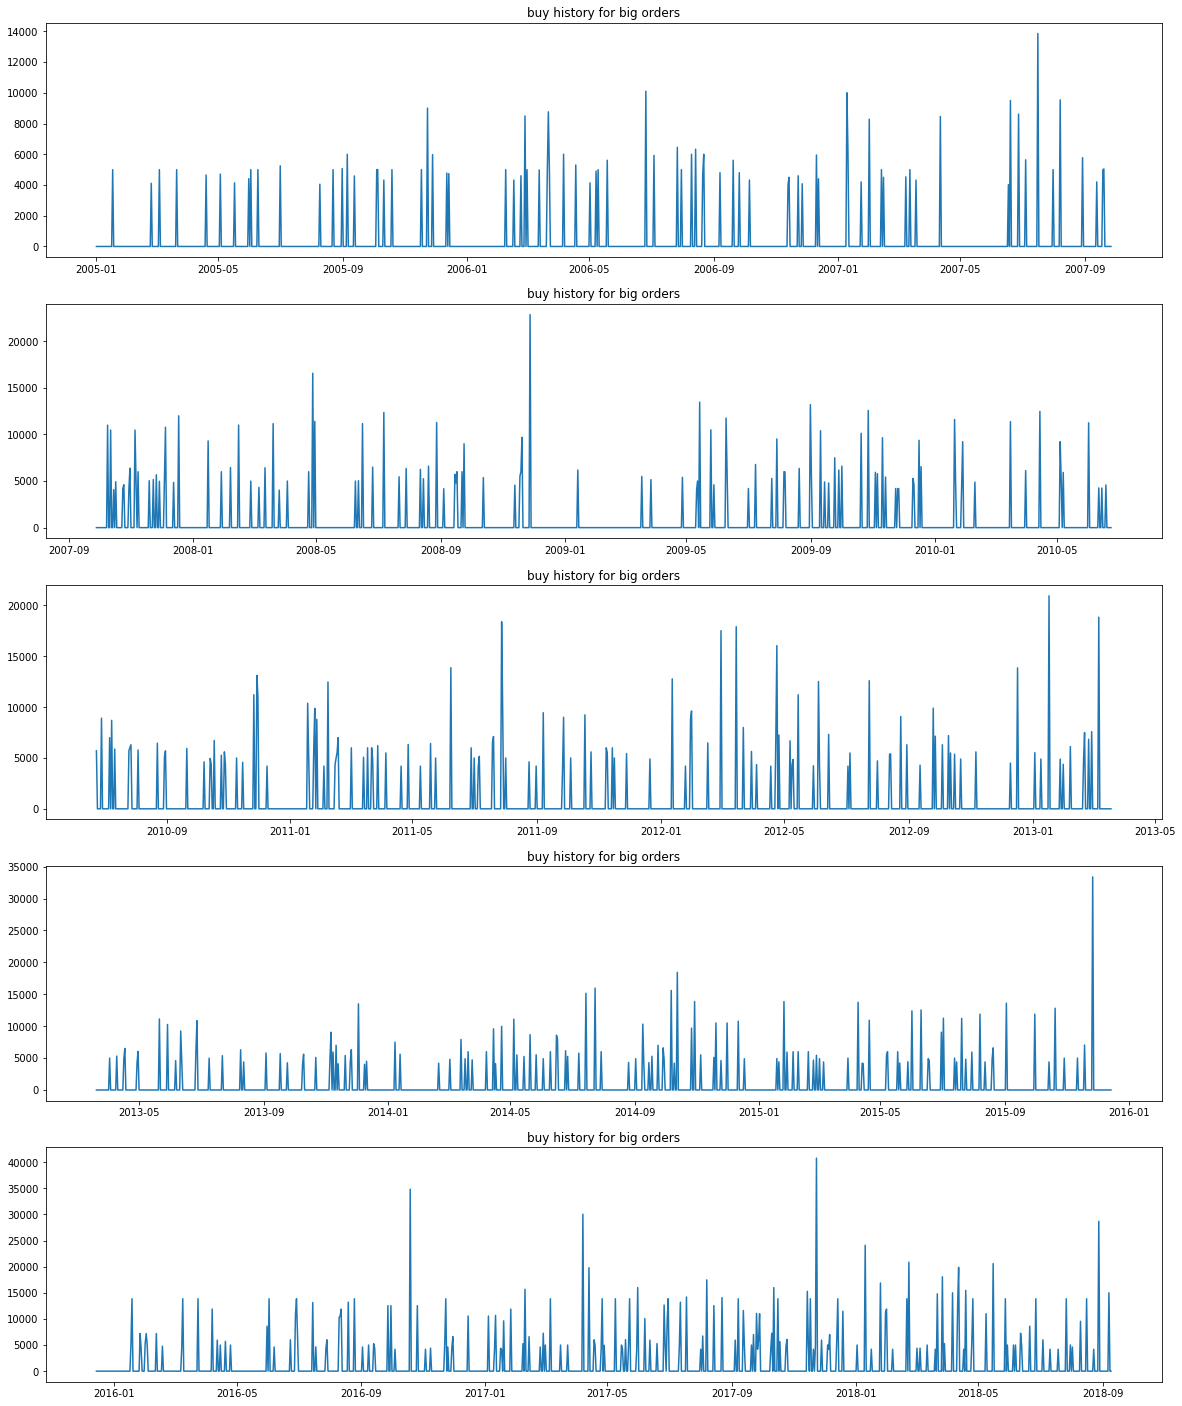

In [155]:
f, axs = plt.subplots(5, 1, figsize=(20, 25))
axs[0].plot(df_200.iloc[0:1000,:])
axs[0].set_title('buy history for big orders')
axs[1].plot(df_200.iloc[1000:2000,:])
axs[1].set_title('buy history for big orders')
axs[2].plot(df_200.iloc[2000:3000,:])
axs[2].set_title('buy history for big orders')
axs[3].plot(df_200.iloc[3000:4000,:])
axs[3].set_title('buy history for big orders')
axs[4].plot(df_200.iloc[4000:5000,:])
axs[4].set_title('buy history for big orders')


In [150]:
tmp = df[df['Menge'] < 2000]
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)
# choose the target article and agg the menge
df_200 = tmp[['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

Text(0.5, 1.0, 'buy history for big orders')

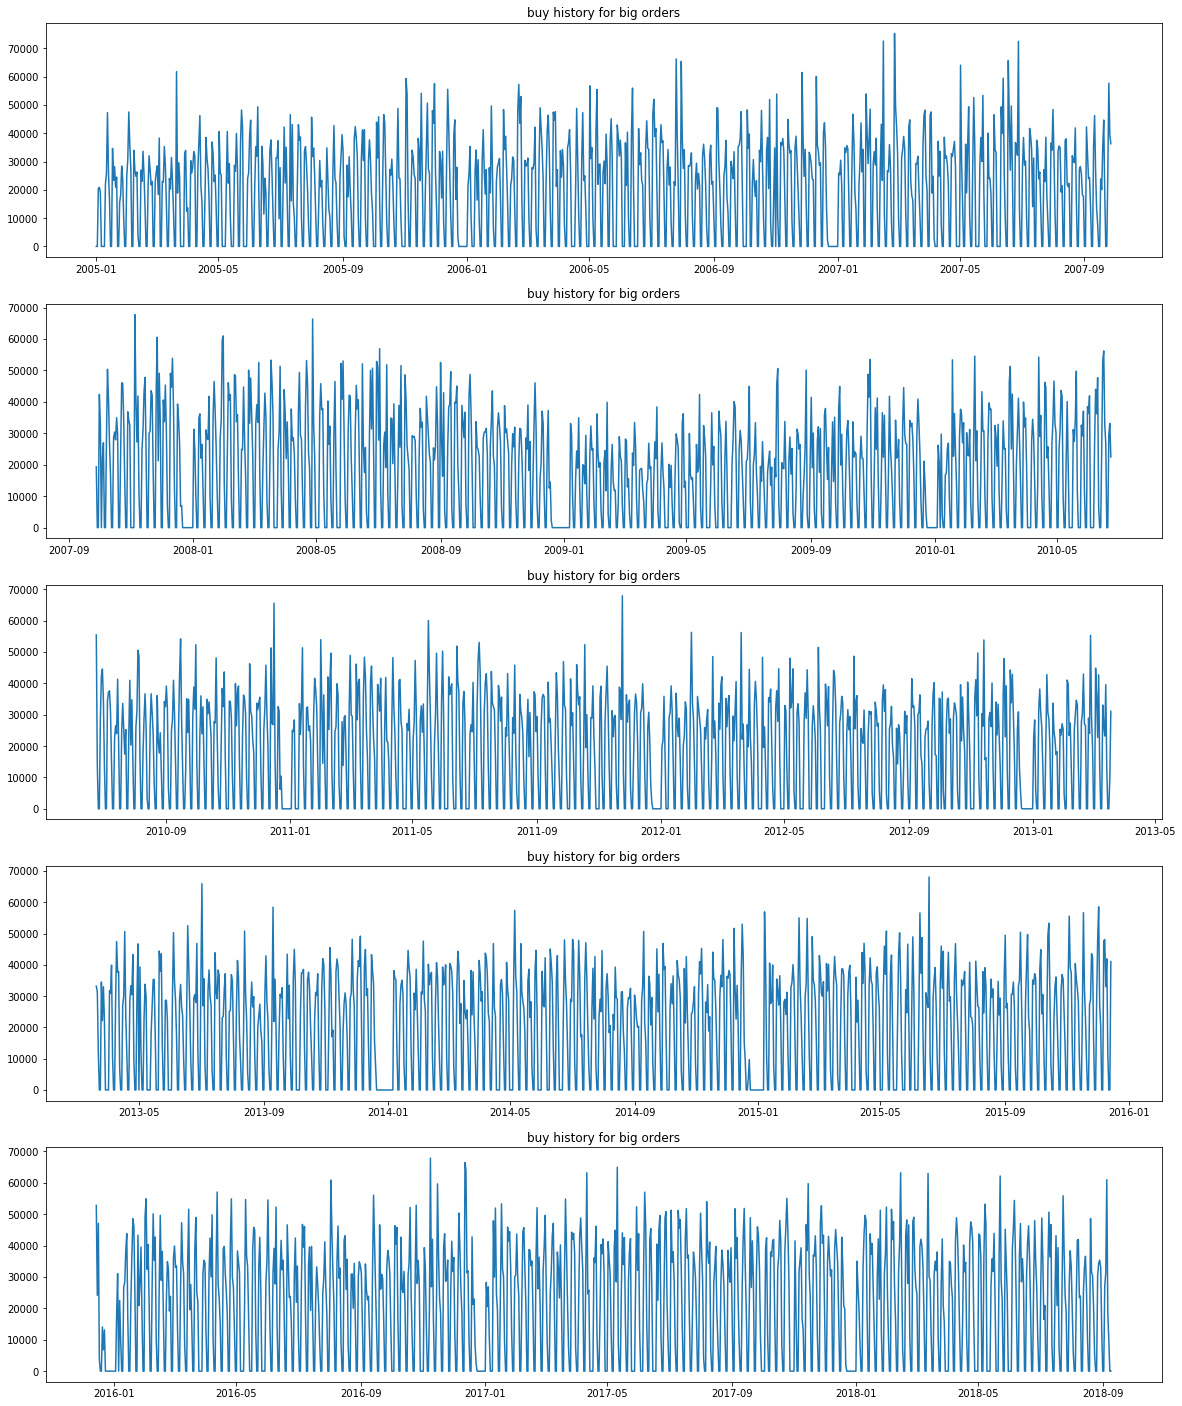

In [151]:
f, axs = plt.subplots(5, 1, figsize=(20, 25))
axs[0].plot(df_200.iloc[0:1000,:])
axs[0].set_title('buy history for big orders')
axs[1].plot(df_200.iloc[1000:2000,:])
axs[1].set_title('buy history for big orders')
axs[2].plot(df_200.iloc[2000:3000,:])
axs[2].set_title('buy history for big orders')
axs[3].plot(df_200.iloc[3000:4000,:])
axs[3].set_title('buy history for big orders')
axs[4].plot(df_200.iloc[4000:5000,:])
axs[4].set_title('buy history for big orders')

## view the cycle of big order for a special article

In [185]:
tmp = df[df['ArtNr'] == '200032']

(array([3.325e+03, 1.416e+03, 1.539e+03, 1.722e+03, 2.213e+03, 1.009e+03,
        5.500e+02, 1.447e+03, 3.700e+02, 1.255e+03, 3.850e+02, 1.006e+03,
        3.740e+02, 1.640e+03, 1.340e+02, 3.970e+02, 1.010e+02, 1.540e+02,
        7.440e+02, 2.740e+02, 7.200e+01, 6.300e+01, 1.210e+02, 1.950e+02,
        3.900e+01, 6.800e+01, 4.000e+01, 9.000e+01, 1.360e+02, 3.000e+01,
        2.700e+01, 4.500e+01, 1.300e+01, 2.300e+01, 2.500e+01, 1.900e+01,
        3.500e+01, 1.000e+01, 4.600e+01, 1.800e+01, 6.200e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  20. ,   44.4,   68.8,   93.2,  117.6,  142. ,  166.4,  190.8,
         215.2,  239.6,  264. ,  288.4,  312.8,  337.2,  361.6,  386. ,
         410.4,  434.8,  459.2,  483.6,  508. ,  532.4,  556.8,  581.2,
         605.6,  630. ,  654.4,  678.8,  703.2,  727.6,  752. ,  776.4,
         800.8,  825.2,  849.6,  874. ,  898.4,  922.8,  947.2,  971.6,
         996. , 

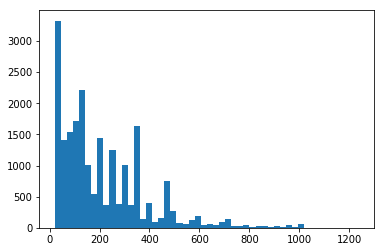

In [186]:
plt.hist(tmp['Menge'], bins = 50)

In [189]:
# how are big order for a tipycal article
tmp = df[df['Menge'] > 400]
tmp = tmp[tmp['ArtNr'] == '200032']
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)
# choose the target article and agg the menge
df_200 = tmp[['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

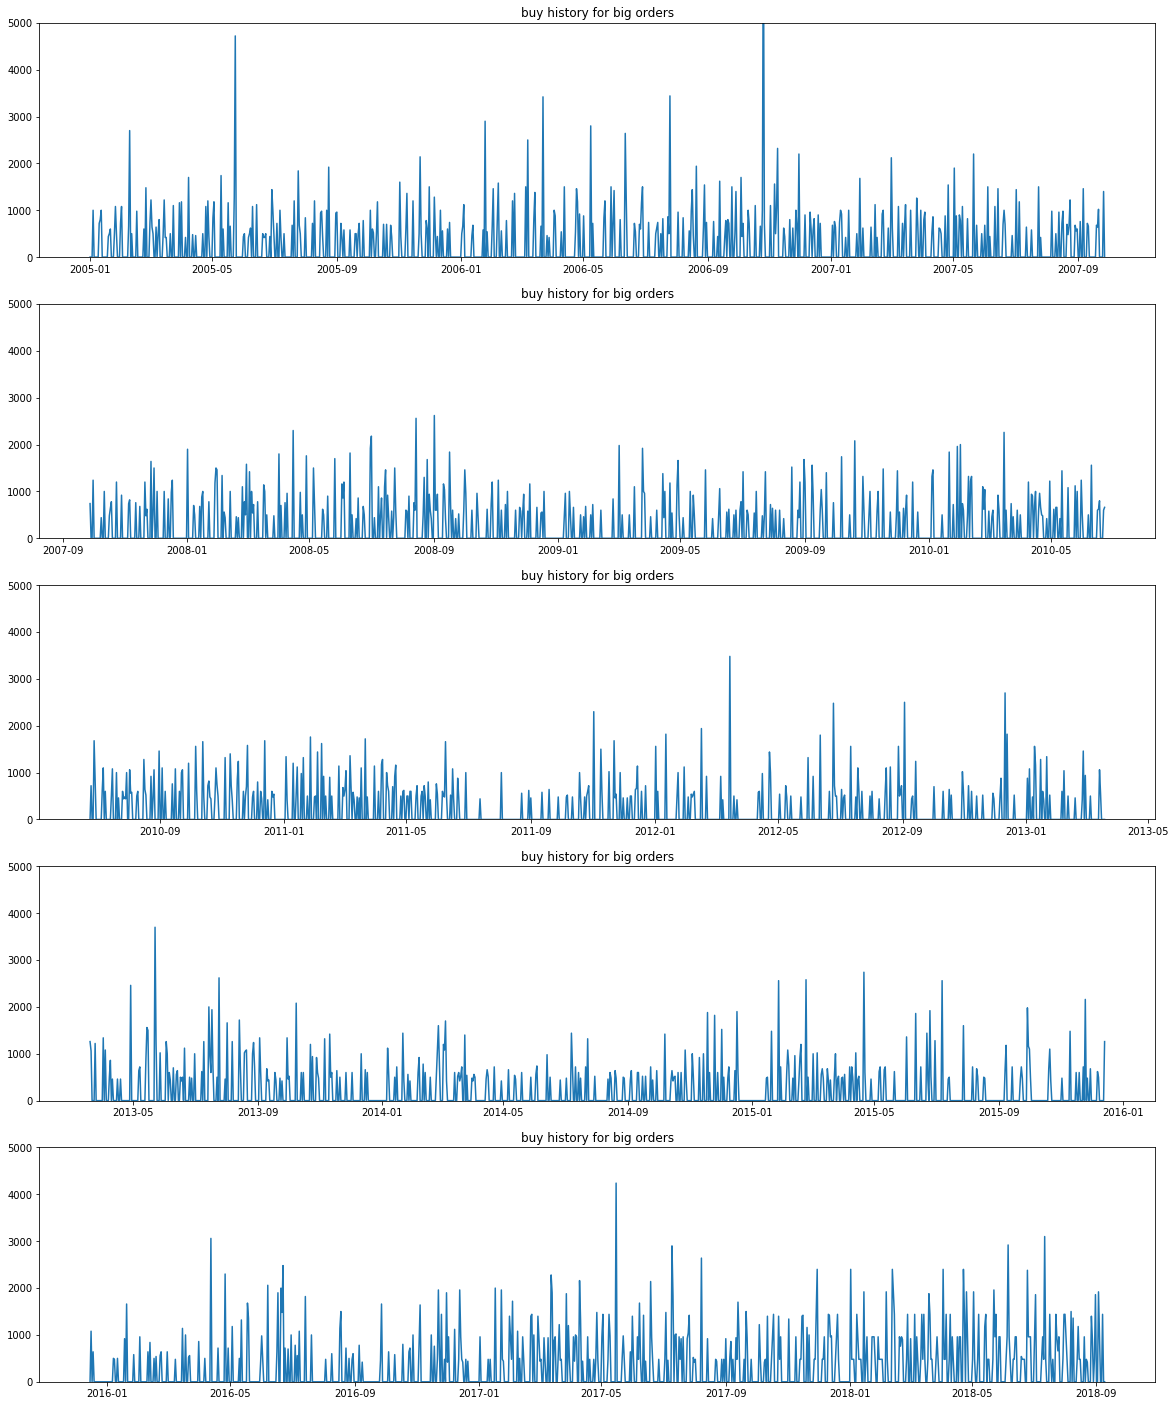

In [192]:
f, axs = plt.subplots(5, 1, figsize=(20, 25))
axs[0].plot(df_200.iloc[0:1000,:])
axs[0].set_title('buy history for big orders')
axs[0].set_ylim([0, 5000])
axs[1].plot(df_200.iloc[1000:2000,:])
axs[1].set_title('buy history for big orders')
axs[1].set_ylim([0, 5000])
axs[2].plot(df_200.iloc[2000:3000,:])
axs[2].set_title('buy history for big orders')
axs[2].set_ylim([0, 5000])
axs[3].plot(df_200.iloc[3000:4000,:])
axs[3].set_title('buy history for big orders')
axs[3].set_ylim([0, 5000])
axs[4].plot(df_200.iloc[4000:5000,:])
axs[4].set_title('buy history for big orders')
axs[4].set_ylim([0, 5000])

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

Text(0.5, 1.0, 'buy history for big orders')

(0, 5000)

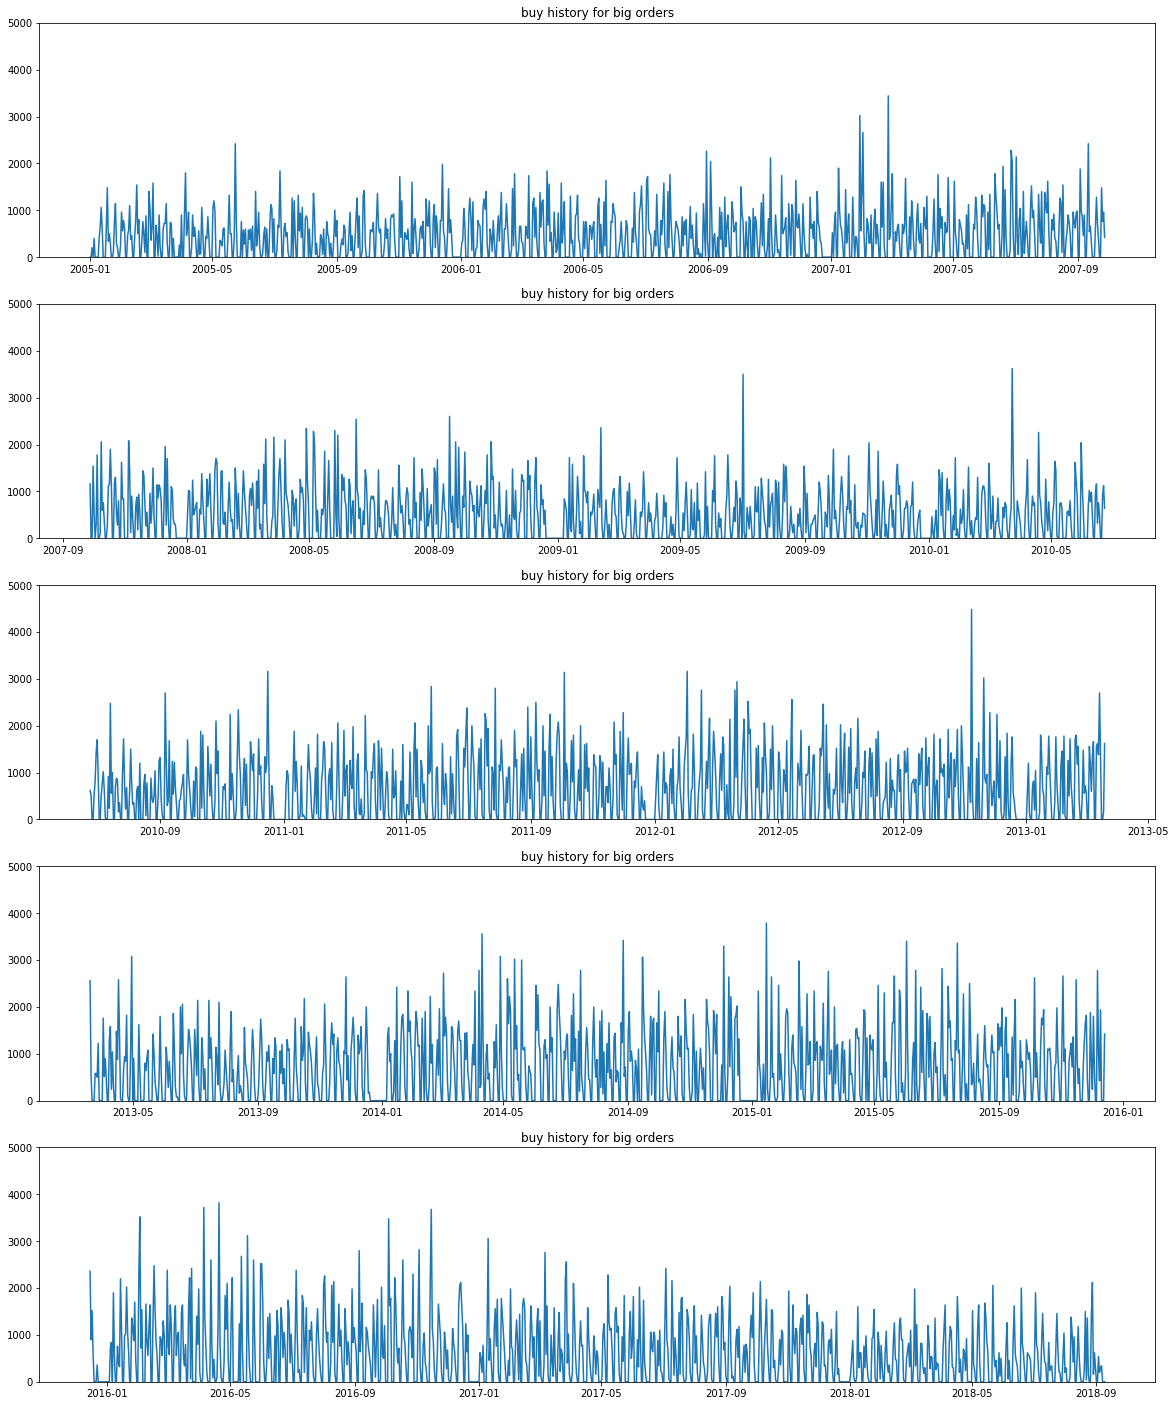

In [193]:
# how are big order for a tipycal article
tmp = df[df['Menge'] <= 400]
tmp = tmp[tmp['ArtNr'] == '200032']
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)
# choose the target article and agg the menge
df_200 = tmp[['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

f, axs = plt.subplots(5, 1, figsize=(20, 25))
axs[0].plot(df_200.iloc[0:1000,:])
axs[0].set_title('buy history for big orders')
axs[0].set_ylim([0, 5000])
axs[1].plot(df_200.iloc[1000:2000,:])
axs[1].set_title('buy history for big orders')
axs[1].set_ylim([0, 5000])
axs[2].plot(df_200.iloc[2000:3000,:])
axs[2].set_title('buy history for big orders')
axs[2].set_ylim([0, 5000])
axs[3].plot(df_200.iloc[3000:4000,:])
axs[3].set_title('buy history for big orders')
axs[3].set_ylim([0, 5000])
axs[4].plot(df_200.iloc[4000:5000,:])
axs[4].set_title('buy history for big orders')
axs[4].set_ylim([0, 5000])

In [194]:
tmp.describe()

,Bew_Jahr,ArtGrp,Menge,Lief_Kd_Nr,weekday,count
count,18782.000,18782.000,18782.000,18782.000,18782.000,18782.000
mean,2012.182,2.000,161.312,2723.571,1.731,3604.605
std,3.918,0.000,110.644,1588.468,1.289,3486.522
min,2005.000,2.000,20.000,3.000,0.000,1.000
25%,2009.000,2.000,60.000,1521.000,1.000,664.000
50%,2012.000,2.000,120.000,2624.000,2.000,1635.000
75%,2015.000,2.000,240.000,3913.000,3.000,6939.000
max,2019.000,2.000,400.000,8002.000,4.000,13333.000
